In [1]:
import torch
import numpy as np
from pathlib import Path
import torch.nn as nn
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
def crnn5(inputdim=64, outputdim=527, pretrained_from='unbalanced'):
    model = CRNN5(inputdim, outputdim)
    pretrained_file = None
    if pretrained_from == 'balanced':
        pretrained_file = 'crnn5_balanced.pth'
    elif pretrained_from == 'balanced_augment':
        pretrained_file = 'crnn5_balanced_augment.pth'
    elif pretrained_from == 'vad':
        pretrained_file = 'crnn5_vad.pth'
    elif pretrained_from == 'unbalanced':
        pretrained_from='crnn5_unbalanced.pth'
    else:
        raise ValueError("pretrained file not found")
    if pretrained_file:
        state = torch.load(Path('.') / pretrained_file)
        model.load_state_dict(state, strict=True)
    return model


class LinearSoftPool(nn.Module):
    """LinearSoftPool

    Linear softmax, takes logits and returns a probability, near to the actual maximum value.
    Taken from the paper:

        A Comparison of Five Multiple Instance Learning Pooling Functions for Sound Event Detection with Weak Labeling
    https://arxiv.org/abs/1810.09050

    """
    def __init__(self, pooldim=1):
        super().__init__()
        self.pooldim = pooldim

    def forward(self, logits, time_decision):
        return (time_decision**2).sum(self.pooldim) / time_decision.sum(
            self.pooldim)
    
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Conv1d)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
def parse_poolingfunction(poolingfunction_name='mean', **kwargs):
    """parse_poolingfunction
    A heler function to parse any temporal pooling
    Pooling is done on dimension 1

    :param poolingfunction_name:
    :param **kwargs:
    """
    poolingfunction_name = poolingfunction_name.lower()
    if poolingfunction_name == 'mean':
        return MeanPool(pooldim=1)
    elif poolingfunction_name == 'linear':
        return LinearSoftPool(pooldim=1)
    
class Block2D(nn.Module):
    def __init__(self, cin, cout, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(cin),
            nn.Conv2d(cin,
                      cout,
                      kernel_size=kernel_size,
                      padding=padding,
                      bias=False),
            nn.LeakyReLU(inplace=True, negative_slope=0.1))

    def forward(self, x):
        return self.block(x)
    
class CRNN5(nn.Module):
    def __init__(self, inputdim, outputdim, **kwargs):
        super().__init__()
        features = nn.ModuleList()
        self.features = nn.Sequential(
            Block2D(1, 32),
            nn.LPPool2d(4, (2, 4)),
            Block2D(32, 128),
            Block2D(128, 128),
            nn.LPPool2d(4, (2, 4)),
            Block2D(128, 128),
            Block2D(128, 128),
            nn.LPPool2d(4, (1, 4)),
            nn.Dropout(0.3),
        )
        with torch.no_grad():
            rnn_input_dim = self.features(torch.randn(1, 1, 500,
                                                      inputdim)).shape
            rnn_input_dim = rnn_input_dim[1] * rnn_input_dim[-1]

        self.gru = nn.GRU(rnn_input_dim,
                          128,
                          bidirectional=True,
                          batch_first=True)
        self.temp_pool = parse_poolingfunction(kwargs.get(
            'temppool', 'linear'),
                                               inputdim=256,
                                               outputdim=outputdim)
        self.outputlayer = nn.Linear(256, outputdim)
        self.features.apply(init_weights)
        self.outputlayer.apply(init_weights)

    def forward(self, x):
        batch, time, dim = x.shape
        x = x.unsqueeze(1)
        x = self.features(x)
        x = x.transpose(1, 2).contiguous().flatten(-2)
        x, _ = self.gru(x)
        decision_time = torch.sigmoid(self.outputlayer(x)).clamp(1e-7, 1.)
        decision_time = torch.nn.functional.interpolate(
            decision_time.transpose(1, 2),
            time,
            mode='linear',
            align_corners=False).transpose(1, 2)
        decision = self.temp_pool(x, decision_time).clamp(1e-7, 1.).squeeze(1)
        return decision, decision_time

/usr/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


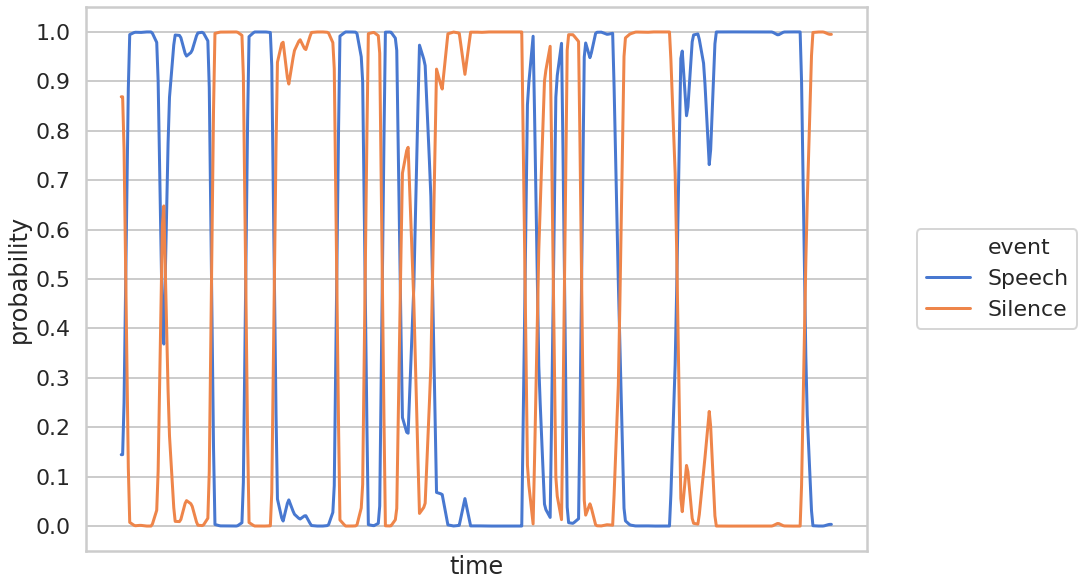

In [135]:
model = crnn5(outputdim=2, pretrained_from='vad').eval()
# model = crnn5(outputdim=527, pretrained_from='balanced').eval()
# EPS = np.spacing(1)
EPS = 1e-4
data = np.log(librosa.feature.melspectrogram(librosa.load('YTim7zUFj1f4_50.000_60.000.wav', sr=22050)[0], hop_length=int(22050*0.02), n_fft=2048, win_length=int(22050*0.04),n_mels=64 ) + 1e-7).T
 
encoder = torch.load('encoder_vad.pth')
# encoder = torch.load('encoder_unbalanced.pth')
# encoder=torch.load('balanced.pth')
with torch.no_grad():
    clip_pred, time_pred = model(torch.as_tensor(data).unsqueeze(0))
    top_k = torch.topk(clip_pred, 2)
    top_k_idx = top_k[1].squeeze(0).numpy()
    classes_ = encoder.classes_[top_k_idx]
    time_pred = time_pred.squeeze(0).numpy()[...,top_k_idx]
    df = pd.DataFrame(time_pred,columns=classes_)
df = df.rename_axis('x').reset_index().melt(id_vars='x').rename({'variable':'event','value':'probability'}, axis='columns')
sns.set(context='poster',style='whitegrid')
fig, ax = plt.subplots(figsize=(14,10))
g = sns.lineplot(data=df, x='x',y='probability',palette='muted',hue='event', ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.xticks([])
plt.yticks(np.arange(0,1.01,step=0.1))
plt.xlabel("time")
plt.show()